# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import pyshtools
import sys, time, os.path
from itertools import permutations
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

In [8]:
import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

mu0 = 300/3;
mu = 1.; nu = 0.499;
lJmax = 10; lKmax = 10; lmax_plot = 60;

shtype = 'reg'

Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

In [9]:
from scipy.sparse.linalg import lsqr, spsolve

# procedures for transformation between Uvec and Tvec
def Uvec2Tvec(Uvec, Cmat, Dmat, disp=False, solver=lsqr):
    tic = time.time()
    #B = lsqr(Dmat, Uvec.T)
    B_sol = spsolve(Dmat, Uvec.T)
    toc = time.time()
    print('Time: %.4fs'%(toc-tic))
    #B_sol = B[0]
    #print('Residual:', B[3], 'Time:', toc-tic, 'Solution:', B_sol.size)
    if disp:
        disp_index_sol = print_SH_mode(B_sol, m_dir=3, etol=1e-8)
    return Cmat.dot(B_sol)

def Tvec2Uvec(Tvec, Cmat, Dmat, disp=False, solver=lsqr):
    tic = time.time()
    A = lsqr(Cmat, Tvec.T, atol=0, btol=0, conlim=0)
    #A_sol = spsolve(Cmat, Tvec.T)
    toc = time.time()
    #print('Time: %.4fs'%(toc-tic))
    A_sol = A[0]
    print('Residual:', A[3], 'Time:', toc-tic, 'Solution:', A_sol.size)
    if disp:
        disp_index_sol = print_SH_mode(A_sol, m_dir=3, etol=1e-8)
    return Dmat.dot(A_sol)

def SHVec2mesh(xvec, lmax=None, SphCoord=True, Complex=False):
    if lmax is None:
        lmax = (np.sqrt(xvec.size/3) - 1).astype(np.int)
    cvec = xvec.reshape(3, -1)
    nvec = cvec.shape[1]
    xmesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cext = np.zeros((lmax+1)**2, dtype=np.complex)
            cext[:nvec] = cvec[k, :]
            cilm = SHVectorToCilm(cext)
        else:
            cext = np.zeros((lmax+1)**2)
            cext[:nvec] = cvec[k, :]
            cilm = pyshtools.shio.SHVectorToCilm(cext)
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        xmesh[k] = grid.to_array().real
    xmesh = np.stack(xmesh, axis=-1)
    if SphCoord:
        Q = TransMat(lJmax=lmax)
        xmesh = np.sum(Q*xmesh[...,np.newaxis,:], axis=-1)
    return xmesh

# visualizing SHvectors in 2D
def visSHVec(xvec, lmax_plot=None, cmap='viridis', show=True, 
             SphCoord=True, config_quiver=(2, 4, 'k', 1), n_vrange=None,
             lonshift=0, Complex=False, figsize=(10, 5)):
    xmesh = SHVec2mesh(xvec, lmax=lmax_plot, SphCoord=SphCoord, Complex=Complex)
    if SphCoord:
        fig = [None for _ in range(2)]
        ax = [None for _ in range(2)]
        xshear= np.linalg.norm(xmesh[...,1:], axis=-1)
        
        fig[0], ax[0] = plotfv(xmesh[...,0], show=False, cmap=cmap,vrange=n_vrange,
                               lonshift=lonshift, figsize=figsize)
        ax[0].set_title('norm')
        
        fig[1], ax[1] = plotfv(xshear, show=False, cmap='Reds', lonshift=lonshift, figsize=figsize)
        latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
        lons, lats = np.meshgrid(lonsdeg, latsdeg)
        xshift = np.roll(xmesh, np.round(lons.shape[1]*lonshift/360).astype(np.int), axis=1)
        st, dq, color, scale = config_quiver
        ax[1].quiver(lons[::dq,st::dq], lats[::dq,st::dq], 
                     xshift[::dq,st::dq,1], xshift[::dq,st::dq,2], 
                     color=color, scale=scale)
        ax[1].set_title('shear')
    else:
        fig = [None for _ in range(3)]
        ax = [None for _ in range(3)]
        titlestr = ('x', 'y', 'z')
        for k in range(3):
            fig[k], ax[k] = plotfv(xmesh[...,k], show=False, cmap=cmap, lonshift=lonshift, figsize=figsize)
            ax[k].set_title('$'+titlestr[k]+'$')
    if show:
        plt.show()
    return fig, ax

# visualizing SHvectors in 3D
def visSH3d(xmesh, cmesh=None, r0=1, lmax_plot=None,
            figsize=(16,16), show=True, filename=None,
            elevation=0, azimuth=0, surface=False, color=None):
    if lmax_plot is None:
        lmax_plot = xmesh.shape[0] - 1
    lats, lons = pyshtools.expand.GLQGridCoord(lmax_plot)
    nlat = lats.size; nlon = lons.size;

    lats_circular = np.hstack(([90.], lats, [-90.]))
    lons_circular = np.append(lons, [lons[0]])
    u = np.radians(lons_circular)
    v = np.radians(90. - lats_circular)
    normvec = np.zeros((nlat+2, nlon+1, 3))
    normvec[...,0] = np.sin(v)[:, None] * np.cos(u)[None, :]
    normvec[...,1] = np.sin(v)[:, None] * np.sin(u)[None, :]
    normvec[...,2] = np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :]

    upoints = np.zeros((nlat + 2, nlon + 1, 3))
    upoints[1:-1, :-1, :] = xmesh
    upoints[0, :, :] = np.mean(xmesh[0,:,:], axis=0)  # not exact !
    upoints[-1, :, :] = np.mean(xmesh[-1,:,:], axis=0)  # not exact !
    upoints[1:-1, -1, :] = xmesh[:, 0, :]
    upoints *= r0
    
    x = r0 * np.sin(v)[:, None] * np.cos(u)[None, :]  + upoints[..., 0]
    y = r0 * np.sin(v)[:, None] * np.sin(u)[None, :] + upoints[..., 1]
    z = r0 * np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :] + upoints[...,2]

    if color is None:
        if cmesh is None:
            magn_point = np.sum(normvec * upoints, axis=-1)
        else:
            tpoints = np.zeros((nlat + 2, nlon + 1, 3))
            tpoints[1:-1, :-1, :] = cmesh
            tpoints[0, :, :] = np.mean(cmesh[0,:,:], axis=0)  # not exact !
            tpoints[-1, :, :] = np.mean(cmesh[-1,:,:], axis=0)  # not exact !
            tpoints[1:-1, -1, :] = cmesh[:, 0, :]
            magn_point = np.sum(normvec * tpoints, axis=-1)
        magn_face = 1./4. * (magn_point[1:, 1:] + magn_point[:-1, 1:] +
                             magn_point[1:, :-1] + magn_point[:-1, :-1])
        magnmax_face = np.max(np.abs(magn_face))
        magnmax_point = np.max(np.abs(magn_point))
        norm = plt.Normalize(-magnmax_face / 2., magnmax_face / 2., clip=True)
        cmap = plt.get_cmap('RdBu_r')
        colors = cmap(norm(magn_face.flatten()))
        colors = colors.reshape(nlat + 1, nlon, 4)

    fig = plt.figure(figsize=figsize)
    ax3d = fig.add_subplot(1, 1, 1, projection='3d')
    if surface:
        if color is None:
            ax3d.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=colors)
        else:
            ax3d.plot_surface(x, y, z, rstride=1, cstride=1, color=color)
    else:
        ax3d.scatter(x, y, z)
    ax3d.view_init(elev=elevation, azim=azimuth)
    ax3d.tick_params(labelsize=16)

    if filename is not None:
        plt.tight_layout()
        fig.savefig(filename,transparent=True)
    if show:
        plt.show(block=True)
    return fig, ax3d

# convert between complex and real SH vectors

def SHvec_rtoc(xvec):
    rcilm = pyshtools.shio.SHVectorToCilm(xvec)
    ccilm = pyshtools.shio.SHrtoc(rcilm)
    cilm = np.zeros_like(ccilm, dtype=np.complex)
    cilm[0,...] = ccilm[0,...] + 1.j*ccilm[1,...]
    cilm[1,:,1:] = (-1)**m_coeffs(lJmax)[0,:,1:] * cilm[0,:,1:].conj()
    return SHCilmToVector(cilm)

def SHvec_ctor(xvec):
    cilm = SHVectorToCilm(xvec)
    ccilm = np.zeros_like(cilm, dtype=np.float)
    ccilm[0,...] = cilm[0,...].real
    ccilm[1,...] = cilm[0,...].imag
    rcilm = pyshtools.shio.SHctor(ccilm)
    return pyshtools.shio.SHCilmToVector(rcilm)

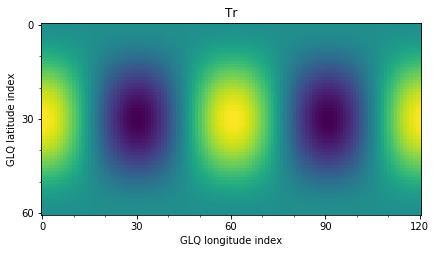

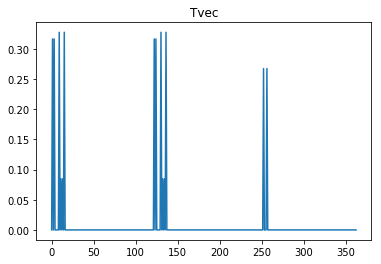

Residual: 7.919973176047217e-12 Time: 0.014528274536132812 Solution: 363


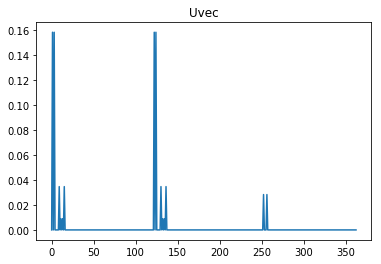

Displacement in Spherical Coordinates...


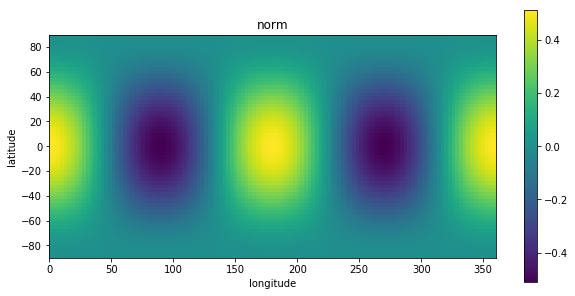

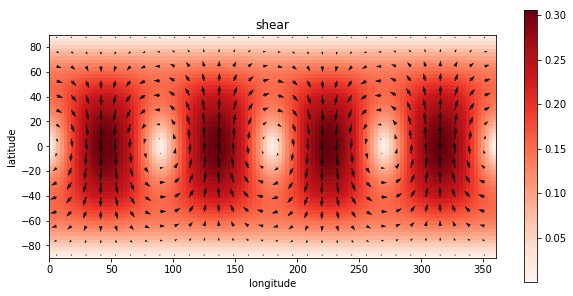

In [31]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

import math, random

def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points

# set an arbitrary normal traction for testing
Trdata_coeff = pyshtools.SHCoeffs.from_zeros(lmax=lJmax)
vlmtest = 1; ltest = 2; mtest = 2;
Trdata_coeff.set_coeffs(vlmtest, ltest, mtest)
fig, ax = Trdata_coeff.pad(lmax=lmax_plot).expand('GLQ').plot(show=False)
ax.set_title('Tr'); plt.show();
Tsph_ref = np.zeros((lJmax+1, 2*lJmax+1, 3))
Tsph_ref[..., 0] = Trdata_coeff.expand('GLQ').to_array()
Q = TransMat(lJmax=lJmax)
Tmesh_ref = np.sum(Q*Tsph_ref[...,np.newaxis], axis=-2)

Tvec_ref = np.zeros((3, (lJmax+1)**2), dtype=np.complex)
for k in range(3):
    Tgrid = pyshtools.SHGrid.from_array(Tmesh_ref[..., k].astype(np.complex), grid='GLQ')
    Tvec_ref[k, ...] = SHCilmToVector(Tgrid.expand().to_array())
Tvec_ref = Tvec_ref.flatten()
plt.plot(np.abs(Tvec_ref)); plt.title('Tvec'); plt.show();

Uvec_ref = Tvec2Uvec(Tvec_ref, Cmat, Dmat)
plt.plot(np.abs(Uvec_ref)); plt.title('Uvec'); plt.show();
print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(Uvec_ref, lmax_plot=lmax_plot, lonshift=180, Complex=True,
                   config_quiver=(2, 4, 'k', 10))
#Umesh_ref = SHVec2mesh(Uvec_ref, lmax=lJmax, Complex=True, SphCoord=False)
#print(Umesh_ref.shape)

In [37]:
n_data = 8000; r0 = 5.26;
Vp = np.stack(fibonacci_sphere(samples=n_data), axis=0)*r0
Vr, Vtheta, Vphi = CartCoord_to_SphCoord(Vp[:,0], Vp[:,1], Vp[:,2])
Vlats = 90 - np.rad2deg(Vtheta); Vlons = np.rad2deg(Vphi);

Umesh_ref = np.zeros(n_data, 3); Ucvec_ref = Uvec_ref.reshape(3, -1);
for k in range(3):
    Ucoeff = pyshtools.SHCoeffs.from_array(SHVectorToCilm(Uvec_ref[k]))
    Umesh_ref[..., k] = Ucoeff.expand(lat=Vlats, lon=Vlons)


#urref = urdata_coeff.expand(lat=Vlats, lon=Vlons)
#print(urref.shape)
err = (1./3.2)+np.sin(Vtheta)*(1.-1./3.2)
Vr = r0 + urref + np.random.normal(loc=0.0, scale=0.05, size=n_data)/err
Vp[:,0],Vp[:,1],Vp[:,2] = SphCoord_to_CartCoord(Vr, Vtheta, Vphi)

from scipy.spatial import Delaunay
Fs = Delaunay(np.vstack([Vtheta, Vphi]).T).simplices
Np = Vp.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)
Tfv = np.zeros(n_data, dtype=np.bool)
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

id of nodes, edges, facets: (8000,) (23979, 2) (15980, 3)
coord of nodes, edges, facets: (8000, 3) (23979, 2, 3) (15980, 3, 3)
Traction free boundary of v, e, f: (8000,) (23979,) (15980,)


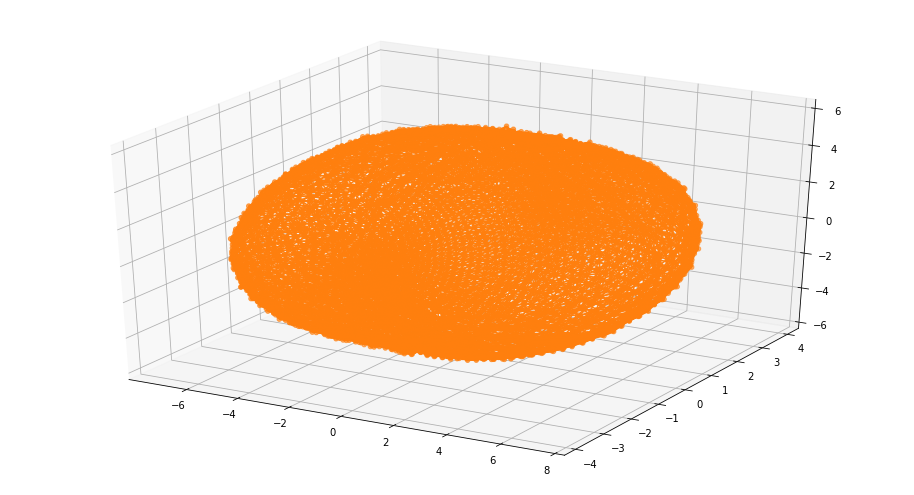

In [41]:
#### Plot the geometry ####

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')

eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
ax.add_collection(eTf)
nTfe = np.logical_not(Tfe)
eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
ax.add_collection(eTf)

ax.view_init()#azim=0, elev=0)
ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [42]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 673.9329, r0 = 5.4389


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only
2. LSQ solving spherical harmonic coefficients for the displacement field
3. LSQ solving SH coeffs for the traction-free boundary

## 1. Assume $r$-direction deformation only

First thing to try is assuming that the deformation only happens on $r$-direction.

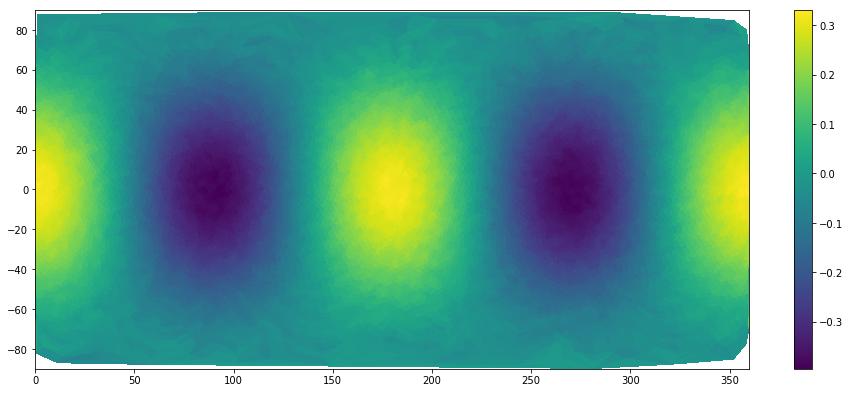

(8000, 3)


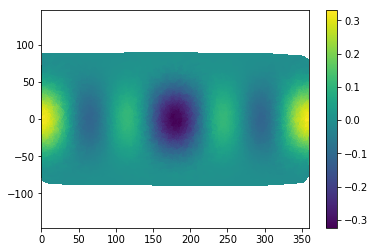

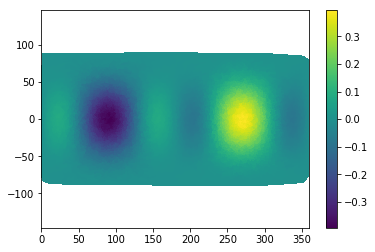

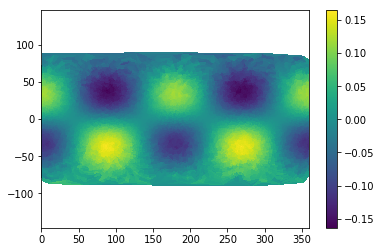

In [43]:
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[:,0], Vp[:,1], Vp[:,2])
#Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# plot 2d map of the radial displacement
pVlon = Vlon
plt.figure(figsize=(16,6.6))
plt.tripcolor(pVlon, Vlat, ur)
plt.colorbar()
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.show()

# displacement on the unit sphere
#u1 = -(r0/Vr[:,np.newaxis]-1)*Vp/r0 #(Vr/r0-1)[...,np.newaxis]*Vp
u1 = ur[:,np.newaxis] * (Vp/Vr[:,np.newaxis])

print(u1.shape)
plt.tripcolor(pVlon, Vlat, u1[:,0])
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.colorbar()
plt.show()
plt.tripcolor(pVlon, Vlat, u1[:,1])
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.colorbar()
plt.show()
plt.tripcolor(pVlon, Vlat, u1[:,2])
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.colorbar()
plt.show()

Residual: 0.27536125612406925
Residual: 0.26998148912122466
Residual: 0.5475263121804457
Displacement SH vector (real, complex): (363,) (363,)


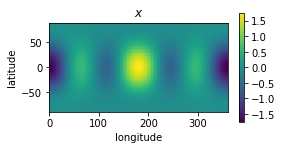

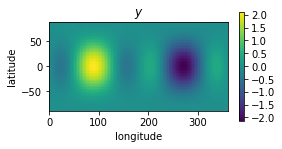

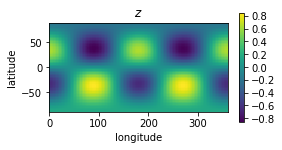

Displacement in Spherical Coordinates...


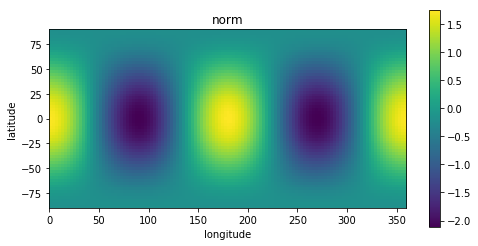

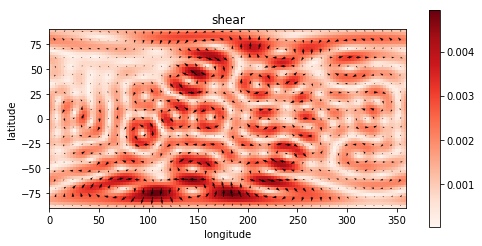

(61, 121, 3)


In [46]:
# decompose the displacement field into spherical harmonic coefficients

Uvec_real = [None for _ in range(3)]
Uvec0 = [None for _ in range(3)]
for k in range(3):
    rcilm, chi2 = pyshtools.expand.SHExpandLSQ(u1[:,k], Vlat, Vlon, lmax=lJmax)
    print('Residual:', chi2)
    Uvec_real[k] = pyshtools.shio.SHCilmToVector(rcilm)
    Uvec0[k] = SHvec_rtoc(Uvec_real[k])
Uvec_real = np.hstack(Uvec_real)
Uvec0 = np.hstack(Uvec0)
print('Displacement SH vector (real, complex):', Uvec_real.shape, Uvec0.shape)
# fig, ax = visSHVec(Uvec_real*r0, lmax_plot=lmax_plot, SphCoord=False, lonshift=180, figsize=(6,3))
fig, ax = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=False, Complex=True, lonshift=180, figsize=(4,2))

print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                   config_quiver=(2, 3, 'k', 0.2), lonshift=180, figsize=(8,4))
Umesh_sph = SHVec2mesh(Uvec0*r0, lmax=lmax_plot, SphCoord=True, Complex=True)
print(Umesh_sph.shape)

1.1026494056742158
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 5


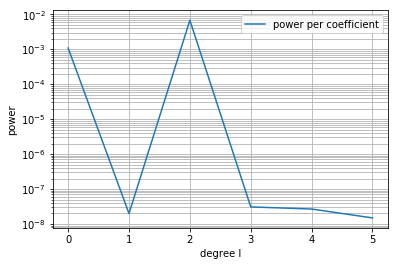

In [47]:
lmax_test = 5
urcilm, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lmax_test)
print(chi2)
urcoeffs = pyshtools.SHCoeffs.from_array(urcilm)
urcoeffs.info()
fig,ax=urcoeffs.plot_spectrum(unit='per_lm')

kind = 'real'
grid = 'GLQ'
nlat = 61
nlon = 121
lmax = 60


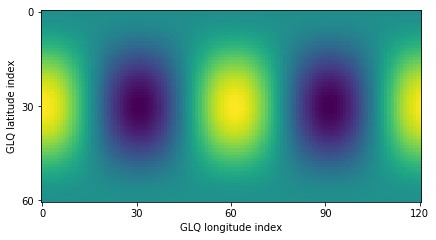

In [48]:
urgrid = urcoeffs.pad(lmax=lmax_plot).expand('GLQ')
urgrid.info()
urgrid.data = np.roll(urgrid.data, lmax_plot+1, axis=1)
fig, ax = urgrid.plot()

(61, 121, 3, 3)
(61, 121, 3)
Displacement in Spherical Coordinates...


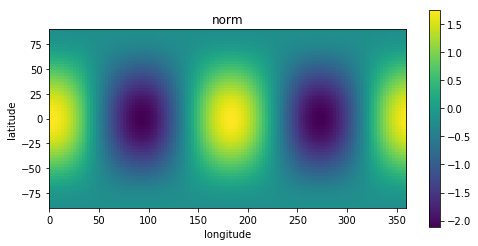

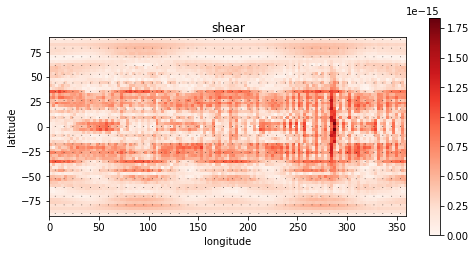

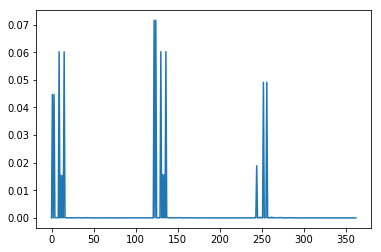

In [49]:
# Convert Back to ux,uy,uz on regular mesh

Q = TransMat(lJmax=lmax_plot)
print(Q.shape)
u1a = urgrid.data[:,:,np.newaxis]*Q[:,:,0,:]
print(u1a.shape)

# decompose the displacement field into spherical harmonic coefficients
Uvec0 = [None for _ in range(3)]
for k in range(3):
    u0grid = pyshtools.SHGrid.from_array(u1a[...,k].astype(np.complex), grid='GLQ')
    u0coeffs = u0grid.expand().pad(lmax=lJmax)
    Uvec0[k] = SHCilmToVector(u0coeffs.to_array())
Uvec0 = np.hstack(Uvec0)

print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                       config_quiver=(2, 3, 'k', 0.2), lonshift=0, figsize=(8,4))
umesh0sph = SHVec2mesh(Uvec0*r0, lmax=lmax_plot, SphCoord=True, Complex=True)
umesh0 = SHVec2mesh(Uvec0, lmax=lmax_plot, SphCoord=False, Complex=True)
plt.plot(np.abs(Uvec0))
#plt.ylim(0,0.0001)
plt.show()

Then we obtain the corresponding traction field.

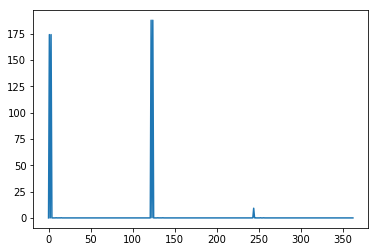

Time: 0.0014s


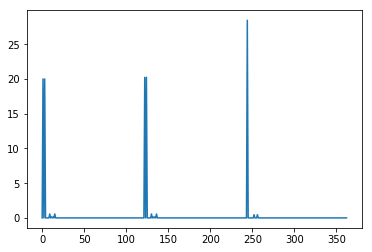

Traction in Spherical Coordinates...


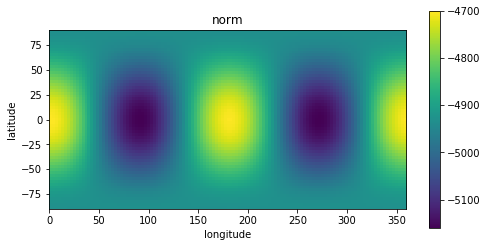

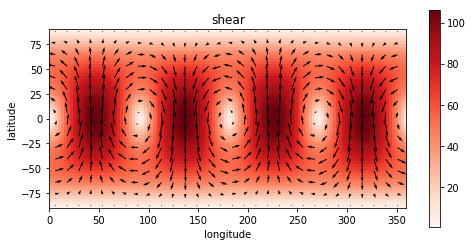

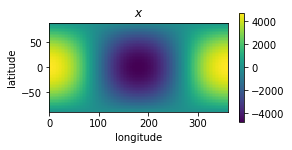

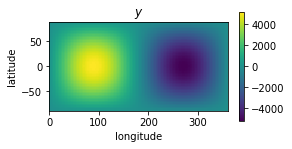

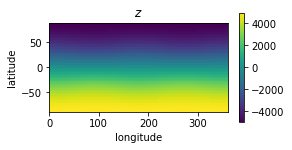

In [50]:
AK = spsolve(Dmat.tocsr(), -Uvec0.T)
plt.plot(np.abs(AK)); plt.show();

Tvec0 = Uvec2Tvec(-Uvec0, Cmat.tocsr(), Dmat.tocsr())
plt.plot(np.abs(Tvec0)); plt.show();
print('Traction in Spherical Coordinates...')
fig, ax = visSHVec(Tvec0*mu0, lmax_plot=lmax_plot, lonshift=180, Complex=True,
                   config_quiver=(2,4,'k',2000), figsize=(8,4))
fig, ax = visSHVec(Tvec0*mu0, lmax_plot=lmax_plot, lonshift=180, Complex=True, SphCoord=False, figsize=(4,2))
tmesh0 = SHVec2mesh(Tvec0, lmax=lmax_plot, Complex=True, SphCoord=False)

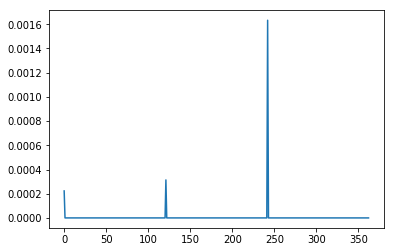

Residual: 4.984227423028626e-12 Time: 0.025016069412231445 Solution: 363


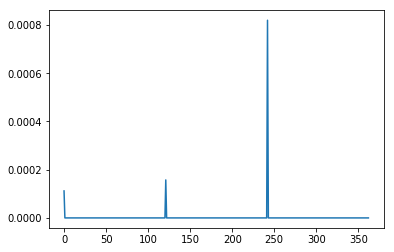

Reconstructed displacement in Spherical Coordinates...


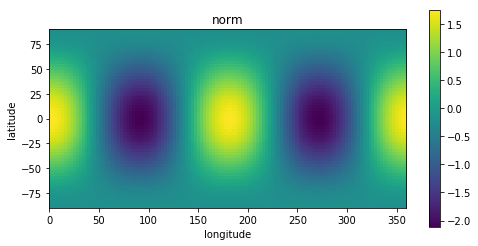

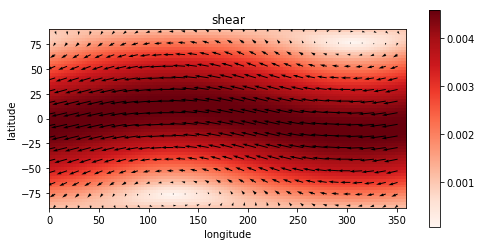

In [51]:
AKa = lsqr(Cmat, Tvec0.T, atol=0, btol=0, conlim=0)
plt.plot(np.abs(AK-AKa[0])); plt.show();

Uvec0a = -Tvec2Uvec(Tvec0, Cmat.tocsr(), Dmat.tocsr())
plt.plot(np.abs(Uvec0a-Uvec0)); plt.show();
print('Reconstructed displacement in Spherical Coordinates...')
fig, ax = visSHVec(Uvec0a*r0, lmax_plot=lmax_plot, lonshift=180, Complex=True,
                   config_quiver=(2,4,'k',0.1), figsize=(8,4))
umesh0a = SHVec2mesh(Uvec0a, lmax=lmax_plot, Complex=True, SphCoord=False)

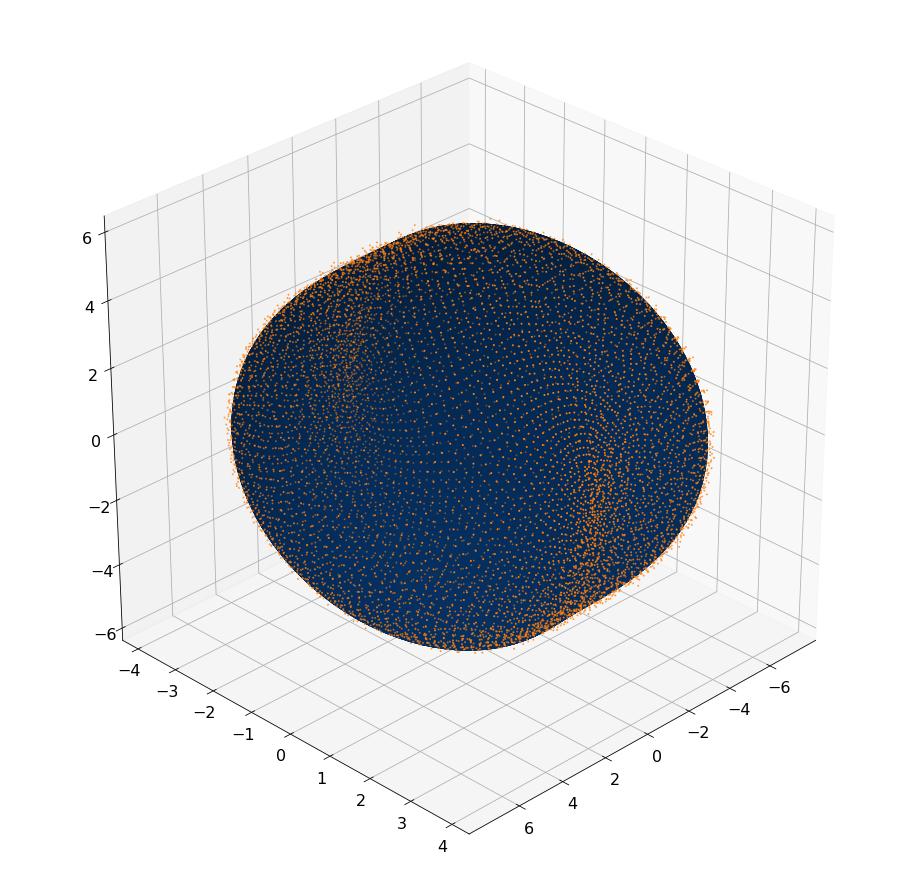

In [15]:
fig, ax = visSH3d(umesh0, cmesh=tmesh0, r0=r0, show=False, elevation=30, azimuth=45, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], s=1)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], s=1)
plt.show()

#np.savez('noise1_true_solution', Uvec=Uvec0, Tvec=Tvec0)

We will see that the traction-free boundary is not well satisfies. Also, there are some viewable torque on the cap, which is obviously unphysical. We will need a better way to obtain the displacement field.

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion. But here we will impose the coefficient for $Y_0^0$ to obtain the rigid body motion.

### 2.1 Developing distance function and neighbor list

We first develop the distance function of the point sets to the surface. The distance of a point $x$ to the surface is defined as: $d(x) = \min[d_{v}(x), d_{e}(x), d_{f}(x)]$, where $d_v(x)$, $d_e(x)$, $d_f(x)$ are the closest distances of $x$ to the vertices, edges, and faces respectively.

* For a vertex $v=(v_1,v_2,v_3)^T$, $d_v(x)=\|\mathbf{x-v}\|_2$. The test script is attached.

In [ ]:
def d2v(Xs, Xv, avg_dist=True, vert_weight=1):
    #### point-to-point distance
    ## Xs: points for testing (..., 3); 
    ## Xv: m data points (m, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## vert_weight: the weighing function for different coordinates (3, )
    d2vmat = np.linalg.norm((Xs[..., np.newaxis, :]-Xv)*vert_weight, axis=-1)   # pair-wise distances (..., m)
    if avg_dist:
        return d2vmat.min(axis=-1).mean()
    else:
        return d2vmat

# test d2v function
Xs = np.array([0,0,0]).reshape(1,3)
Xv = np.random.rand(2,3)
print('Original point', Xs)
print('Vertices', Xv)
print('Distances', d2v(Xs, Xv, avg_dist=False))
print('Min distance', d2v(Xs, Xv))

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')

lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, (2,3)), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)

ax.view_init()
ax.set_aspect('equal')
plt.show()

* For an edge $e=(r_1, r_2)$, the projection point $\vec{r_1q}$ on $\vec{r_1r_2}$ is 
$$
\vec{r_1q} = \frac{\vec{r_1x}\cdot\vec{r_1r_2}}{\|\vec{r_1r_2}\|}\,\frac{\vec{r_1r_2}}{\|\vec{r_1r_2}\|}
$$

The projection is in the interval $r_1r_2$ if $t=\|\vec{r_1q}\|/\|\vec{r_1r_2}\|\in(0,1)$. 
Thus, the distance to the edge is calculated as:
$$
d_e(x)=
\begin{cases}
\|\vec{r_1x}\|,\; t\le0 \\
\|\vec{qx}\|,\; 0<t\le1 \\
\|\vec{r_2x}\|,\; t>1 
\end{cases}
$$
A test case is attached here.

In [ ]:
def d2e(Xs, Xe, e_cached=None, avg_dist=True, infval=False, debug=False):
    #### point-to-edge distance
    ## Xs: points for testing (..., 3); 
    ## Xe: m edges from data (m, 2, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the edge will be consider infinite distance
    ## debug: output info for debug/testing
    if e_cached is None:
        r1 = Xe[..., 0, :]; r2 = Xe[..., 1, :]; r12 = r2 - r1;        # m x 3, edge vertices
        l12 = np.linalg.norm(r12, axis=-1)                            # m,     edge length
    else:
        r1, r12, l12 = e_cached
    t = np.sum((Xs[..., np.newaxis, :]-r1)*r12, axis=-1)/l12**2   # n x m,     projection ratio
    t_cal = t.copy(); t_cal[t<0] = 0; t_cal[t>1] = 1;             # a copy of t for calculation
    q = r1 + (t_cal[...,np.newaxis]*r12)                          # n x m x 3, projection point
    d2emat = np.linalg.norm(Xs[..., np.newaxis, :] - q, axis=-1)  # n x m
    if infval:
        d2emat[np.logical_or(t<0, t>1)] = np.inf
    if avg_dist:
        return d2emat.min(axis=-1).mean()
    else:
        if debug:
            dr1 = np.linalg.norm(Xs[..., np.newaxis, :] - r1, axis=-1)
            dr2 = np.linalg.norm(Xs[..., np.newaxis, :] - r2, axis=-1)
            return (d2emat, q, dr1, dr2)
        else:
            return d2emat

# test d2e function
Xs = np.array([0,0,0]).reshape(1,3)
Xe = np.random.rand(2,2,3)
print('Original point', Xs); print('Edges:'); print(Xe);
d2emat, q, dr1, dr2 = d2e(Xs, Xe, avg_dist=False, debug=True)
q = q.squeeze()
print('Closest dist:', d2emat,'d2r1', dr1,'d2r2', dr2)
print('Actual dist:', d2e(Xs, Xe, avg_dist=False, infval=True))
tic = time.time(); d2emat = d2e(Xs, Xe); toc = time.time()
print('min distance:', d2emat, toc-tic, 's')
r1 = Xe[..., 0, :]; r2 = Xe[..., 1, :]; r12 = r2 - r1;        # m x 3, edge vertices
l12 = np.linalg.norm(r12, axis=-1)
e_cached = (r1, r12, l12)
tic = time.time(); d2emat = d2e(Xs, Xe, e_cached=e_cached); toc = time.time()
print('cached calculation:', d2emat, toc-tic, 's')
Xv = Xe.reshape(4, 3)

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')

edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
ax.add_collection(edges)
lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)
projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
ax.add_collection(projection)

ax.view_init()
ax.set_aspect('equal')
plt.show()

* For a face $f=(r_1, r_2, r_3)$, the normal vector:
$$
n = \frac{\vec{r_1r_2}\times\vec{r_1r_3}}{\|\vec{r_1r_2}\times\vec{r_1r_3}\|}
$$
Then the distance can be calculated as:
$$
d_f(x)=\|\vec{r_1x}\cdot\vec{n}\|
$$
if the projection point $q$ is in the triangle, where $q = x - (\vec{r_1x}\cdot\vec{n})\vec{n}$.

To test this, we calculate the barycentric coordinates of $q$:
$$
b_3 = \frac{\|r_1\|^2\times(\vec{r_1r_3}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_2}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_2 = \frac{\|r_2\|^2\times(\vec{r_1r_2}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_3}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_1 = 1 - b_2 - b_3
$$

If any $b_i < 0$, $q$ is outside of the triangle, we then calculate the point edge distances $d_e(x)$ instead.

In [ ]:
def generate_fcache(Xf):
    r0 = Xf[..., 0, :]; r1 = Xf[..., 1, :]; r2 = Xf[..., 2, :];    # m x 3
    nf = np.cross(r1-r0, r2-r0)                                    # normal vector
    nf = nf / np.linalg.norm(nf, axis=-1)[...,np.newaxis]          # m x 3
    r11 = np.sum((r2 - r0)**2, axis=-1)                            # m
    r00 = np.sum((r1 - r0)**2, axis=-1)                            # m
    r01 = np.sum((r1-r0)*(r2-r0), axis=-1)                         # m
    d = r11*r00 - r01*r01                                          # m
    return r0, r1, r2, nf, r00, r11, r01, d

def d2f(Xs, Xf, f_cached=None, avg_dist=True, infval=False, debug=False, vert_weight=1, fasteval=False):
    #### point-to-face distance
    ## Xs: points for testing (..., 3); 
    ## Xf: m faces from data (m, 3, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the face will be consider infinite distance
    ## debug: output info for debug/testing
    ## vert_weight: the weighing function for different coordinates (3, )
    ## fasteval: if True, only calculate the point-vertex distances for estimation.

    if fasteval:
        d2fmat = np.linalg.norm(Xs[...,np.newaxis,np.newaxis,:] - Xf, axis=-1).min(axis=-1)
    else:
        if f_cached is None:
            f_cached = generate_fcache(Xf)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf*vert_weight, axis=-1)     # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.abs(pq)                                            # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.linalg.norm(((Xp[...,np.newaxis,:]-qs)*vert_weight), axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        if debug:
            return (d2fmat, q)
        else:
            return d2fmat

    if avg_dist:
        return d2fmat.min(axis=-1).mean()
    else:
        return d2fmat

# test d2e function
Xs = np.array([0,0,0]).reshape(1,3)
Xf = np.random.rand(2,3,3)-0.5
Xf[0,:,2] = 1
Xf[1,:,1] = 1
Xv = Xf.reshape(6, 3)
print(Xf)
Xe = np.vstack([np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1),
                np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1)])
tic = time.time()
d2fmat, q = d2f(Xs, Xf, avg_dist=False, debug=True);
toc = time.time()
print(toc-tic)

q = np.squeeze(q)
d2e1, q1, _, _ = d2e(Xs, np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
d2e2, q2, _, _ = d2e(Xs, np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
q1 = q1.squeeze(); q2 = q2.squeeze();

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')
ax.scatter3D(q[..., 0], q[..., 1], q[..., 2], 'C2')
print(q)
tic = time.time(); d2fmat = d2f(Xs, Xf); toc = time.time()
print('total distance:', d2fmat, toc-tic, 's')
tic = time.time(); d2fmat = d2f(Xs, Xf, fasteval=True); toc = time.time()
print('fast total distance:', d2fmat, toc-tic, 's')
f_cached = generate_fcache(Xf)
tic = time.time(); d2fmat = d2f(Xs, Xf, f_cached=f_cached); toc = time.time()
print('total distance with cache:', d2fmat, toc-tic, 's')
print(d2e1); print(q1);
print(d2e2); print(q2);

edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
ax.add_collection(edges)
lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)
projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
ax.add_collection(projection)
projection1 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q1.shape), q1]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection1)
projection2 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q2.shape), q2]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection2)

ax.view_init(azim=270, elev=30)
ax.set_aspect('equal')
plt.show()

With the distance function ready, we can develop the neighbor list by choosing the closest 70 vertices, edges and faces to the points:

In [ ]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)
Xt = X0 + SHVec2mesh(Uvec0, lmax=lJmax, SphCoord=False, Complex=True)

In [ ]:
n_list = 200; shapename = 'noise1'; smoothed = ''; dilated = '';
file_neigh_fast = shapename+'_neigh%d_lmax%d'%(n_list, lJmax)+smoothed+dilated+'_Fneigh.npz'
if not os.path.exists(file_neigh_fast):
    d2fmat = d2f(Xt, Fp/r0, avg_dist=False, fasteval=True)
    d2farg = np.argsort(d2fmat)[...,:n_list*2]
    Fn = Fp[d2farg]/r0
    np.savez(file_neigh_fast, Fneigh=Fn)
else:
    Fn = np.load(file_neigh_fast)['Fneigh']
print('Fast facet neighbor:', Fn.shape)

file_neigh = shapename+'_neigh%d_lmax%d'%(n_list, lJmax)+smoothed+dilated+'.npz'
if not os.path.exists(file_neigh):
    print(X0.shape, Vp.shape, Ep.shape, Fn.shape, r0)
    d2vmat = d2v(Xt, Vp/r0, avg_dist=False)
    d2emat = d2e(Xt, Ep/r0, avg_dist=False)
    d2fmat = d2f(Xt, Fn, avg_dist=False)
    print(d2vmat.shape, d2emat.shape, d2fmat.shape)

    d2varg = np.argsort(d2vmat)[...,:n_list]
    d2earg = np.argsort(d2emat)[...,:n_list]
    d2farg = np.argsort(d2fmat)[...,:n_list]
    d2farg0 =np.broadcast_to(np.arange(d2farg.shape[0])[:,np.newaxis,np.newaxis], d2farg.shape)
    d2farg1 =np.broadcast_to(np.arange(d2farg.shape[1])[np.newaxis,:,np.newaxis], d2farg.shape)
    Xneigh = Vp[d2varg]/r0
    Eneigh = Ep[d2earg]/r0
    Fneigh = Fn[(d2farg0, d2farg1, d2farg)]

    np.savez(file_neigh, Xneigh=Xneigh, Eneigh=Eneigh, Fneigh=Fneigh)

n_load = 70
Xneigh = np.load(file_neigh)['Xneigh'][...,:n_load,:]
Eneigh = np.load(file_neigh)['Eneigh'][...,:n_load,:,:]
Fneigh = np.load(file_neigh)['Fneigh'][...,:n_load,:,:]
print('Neighbor list:', Xneigh.shape, Eneigh.shape, Fneigh.shape)

### 2.2  From `uvec` to the shape difference

After we obtain the neighbor list, the shape can be obtained from the real SH vector `uvec`. This can be used for the optimization of the shape.

In [ ]:
def coeffs2dist(xvec, Xt=None, f_cached=None, lmax=None, X0=None, Complex=False, 
                lat_weights=1, vert_weight=1, l_weight=None):
    #### shape difference from SH vectors
    ## xvec: Input real SH vector (3x(lmax+1)^2)
    ## Xt: Input shape data (nv x 3) or (nf x 3 x 3); can be full list or neighbor list
    ## f_cached: Default None, Xt is the coordinates of vertices; otherwise, Xt is the
    ##          coordinates of faces, and f_cached provides the pre-calculated values.
    ## lmax, X0: pre-calculated parameters for speed-up. Explained in the code.
    ## Complex: Default False, xvec is the real SH vector using pyshtools.shio.SHVectorToCilm;
    ##          otherwise, it will be complex SH vector using SHUtil.SHVectorToCilm;
    ## lat_weights: weighing function for different densities of nodes on different lattitudes.
    ## vert_weight: weighing function for different error in different directions
    ## l_weight: weighing function for coefficients (anti-aliasing)
    if lmax is None:
        lmax = np.sqrt(xvec.size/3).astype(np.int) - 1
    nvec = (lmax+1)**2
    cvec = xvec.reshape(3, nvec)
    # expand the displacement field onto a mesh
    umesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cilm = SHVectorToCilm(cvec[k, :])
        else:
            cilm = pyshtools.shio.SHVectorToCilm(cvec[k, :])
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        umesh[k] = grid.to_array().real
    umesh = np.stack(umesh, axis=-1)
    # calculate the shape
    if X0 is None:
        lon = np.deg2rad(grid.lons())
        colat = np.deg2rad(90-grid.lats())
        PHI, THETA = np.meshgrid(lon, colat)
        R = np.ones_like(PHI)
        X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
        X0 = np.stack([X,Y,Z], axis=-1)
    Xs = X0 + umesh

    if f_cached is None:
        d2surf = np.sum(((Xs[..., np.newaxis, :]-Xt))**2*vert_weight, axis=-1).min(axis=-1)
    else:
        #d2surf = d2f(Xs, Xt, f_cached=f_cached, avg_dist=False, vert_weight=vert_weight).min(axis=-1)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached; Xf = Xt;
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf, axis=-1)             # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.sum(((Xs[...,np.newaxis,:]-r0)*nf)**2*vert_weight, axis=-1)   # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.sum(((Xp[...,np.newaxis,:]-qs))**2*vert_weight, axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        d2surf = d2fmat.min(axis=-1)

    
    if l_weight is None:
        regularization = 0
    else:
        regularization = np.linalg.norm(np.tile(l_weight, 3)*xvec)
    return np.sqrt(np.mean(d2surf*lat_weights)) + regularization

We use the solution we obtained from Section 1 `Uvec0` for the testing:

In [ ]:
from SHUtil import LM_list
err_ratio = 1/3.2
#lat_weights = ((1-err_ratio)*np.sin(colat)+err_ratio)**2
lat_weights = np.sin(THETA)**2 #.reshape(-1, 1, 1, 1)
vert_weight = np.array([1,1,1./3])**2
l_list, m_list = LM_list(lJmax)
l_weight = l_list - (lJmax - 3); l_weight[l_weight < 0] = 0; l_weight = 10**l_weight;
print('latitude weight function shape:', lat_weights.shape, vert_weight.shape, l_weight.shape)
#plt.plot(l_weight)
#plt.show()

tic = time.time()
dist_test = coeffs2dist(Uvec0*0, Vp/r0, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare all distances: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(Uvec0*0, Xneigh, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(Uvec0, Xneigh, lmax=lJmax, X0=X0, Complex=True, lat_weights=lat_weights, vert_weight=vert_weight)
toc = time.time()
print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(Uvec0, Xneigh, lmax=lJmax, X0=X0, Complex=True, lat_weights=lat_weights, vert_weight=vert_weight, l_weight=l_weight)
toc = time.time()
print('weighted distance + regularization: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

### 2.4 Solution by minimizing the shape-shape difference

Then we can optimizing the solution by minimizing the distance:

In [ ]:
# minimize the distance by variate coefficients
from scipy.optimize import minimize

uinit = Uvec_real*0 #np.load(shapename+'_Powell.npy').item().x

tic = time.time()
uvec_min = minimize(coeffs2dist, uinit,
                    args=(Xneigh, None, lJmax, X0, False, lat_weights, vert_weight, l_weight), 
                    method='Powell', options={'ftol': 1e-8, 'disp': True})
                #method='CG',options={'gtol': 1e-5, 'disp': True})
toc = time.time()
print('total time', toc-tic)

In [ ]:
print(uvec_min)
plt.plot(uvec_min.x); plt.show()
np.save(shapename+'_Powell_iter1',uvec_min)

tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0)
toc = time.time()
print('the actual v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0, lat_weights=lat_weights)
toc = time.time()
print('node-density weighted v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0, lat_weights=lat_weights, vert_weight=vert_weight)
toc = time.time()
print('noise-weighted v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

In [ ]:
lat_weights = lat_weights.reshape(-1, 1, 1, 1)
Uvec1_real = uvec_min.x.reshape((3, -1)) #(uvec_min.x*l_weight).reshape((3, -1))/r0
Uvec1 = np.zeros_like(Uvec1_real, dtype=np.complex)
for k in range(3):
    Uvec1[k, :] = SHvec_rtoc(Uvec1_real[k, :])
Uvec1 = Uvec1.flatten()
print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(Uvec1*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, config_quiver=(2, 4, 'k', 5), lonshift=180, figsize=(8,4))
umesh1 = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(Uvec1, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, lat_weights=lat_weights, vert_weight=vert_weight, Complex=True)
toc = time.time()
print('noise-weighted v2f distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

In [ ]:
Tvec1 = Uvec2Tvec(Uvec1, Cmat, Dmat)
print('Traction in Spherical Coordinates...')
fig, ax = visSHVec(Tvec1*mu0, lmax_plot=lmax_plot, lonshift=180, Complex=True, config_quiver=(2,4,'k',2000), figsize=(8,4))
tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, Complex=True, SphCoord=False)

In [ ]:
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], s=1)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], s=1)
plt.show()

## 3. Optimize the solution in the solution space to satisfy the mixed BC

The problem actually includes a mixed BC on shape and traction. In order to optimize the two targets together, we use the vector $a^{(K)}$ as the parameters, and we can obtain the traction and shape by superposing the fundamental solutions

$$
\mathbf{T}=a^{(K)}\mathbf{T}^{(K)}\\
\mathbf{u}=a^{(K)}\mathbf{u}^{(K)}
$$
then the shape is calculated as $\mathbf{x}=\mathbf{X}+\mathbf{u}$.

The target function: to do

We first find the nodes that is on the traction free boundary

In [ ]:
umesh = visSHVec(Uvec1, SphCoord=False, Complex=True, config_quiver=(1, 1, 'k', 1), lonshift=180, figsize=(6, 3), mesh=True)
x0 = X0 + umesh
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
isTfv = Tfv[arg_list_x]

print(umesh.shape, X0.shape, isTfv.shape)

Then we optimize the vector $a^{(K)}$:

In [ ]:
lat_weights = lat_weights.flatten()

def sol2dist(aK, Cmat, Dmat, alpha = 0.05, separate=False):
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lJmax+1)**2
    ucvec = Uvec.reshape(3, -1)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    umesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    tmesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    for k in range(3):
        ucilm = SHVectorToCilm(ucvec[k, :])
        ugrid = pyshtools.SHCoeffs.from_array(ucilm).expand('GLQ')
        umesh[..., k] = ugrid.to_array().real
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    Xs = X0 + umesh# + u0.real
    
    d2surf = np.sum((Xs[..., np.newaxis, :]-Xneigh)**2*vert_weight, axis=-1).min(axis=-1)
    Udist = np.sqrt(np.mean(d2surf*lat_weights[:,np.newaxis]))
    tvalues = np.sum(tmesh**2*vert_weight, axis=-1)
    Tdist = np.sqrt(np.mean(tvalues*lat_weights[:,np.newaxis]))
    if separate:
        return (Udist, Tdist)
    return (Udist + alpha*Tdist)*1e3

In [ ]:
from SHUtil import LM_list
A = spm.linalg.lsqr(Cmat, Tvec1.T)
Ainf = A[0]
print(A[3])

alpha = 0.5
tic = time.time()
Asol = sol2dist(Ainf, Cmat, Dmat, alpha=alpha, separate=True)
toc = time.time()
print('infinite traction:', Asol, toc-tic)

In [ ]:
tic = time.time()
Amin = minimize(sol2dist, Ainf,
                args=(Cmat, Dmat, alpha, False), method='Powell', options={'disp': True})
toc = time.time()
print('total time', toc-tic)
#np.save(Aminfile, Amin)

In [ ]:
aKmin = Amin.x
#print(aKmin.shape)
aKmin = Amin.x #Amin.x[:-3];# u0 = Amin.x[-3:];
Tvecmin = Cmat.dot(aKmin)
Uvecmin = Dmat.dot(aKmin)
fig, ax = visSHVec(Tvecmin*mu0, lmax_plot=80, lonshift=180,n_vrange=(-200,200), Complex=True, config_quiver=(2,4,'k', 4000), show=False)
#fig[0].savefig(Aminfile+'_Tn.eps', transparent=True)
#fig[1].savefig(Aminfile+'_Ts.eps', transparent=True)
fig, ax = visSHVec(Uvecmin*r0, lmax_plot=80, lonshift=180, n_vrange=(-0.8,0.8), Complex=True, config_quiver=(2,4,'k', 10))
#fig[0].savefig(Aminfile+'_un.eps', transparent=True)
#fig[1].savefig(Aminfile+'_us.eps', transparent=True)

tic = time.time()
Asol = sol2dist(Amin.x, Cmat, Dmat, alpha=alpha, separate=True)
toc = time.time()
print('infinite traction:', Asol, toc-tic)
#print('point-trimesh distance:',
#      coeffs2dist(Uvecmin, Fneigh, f_cached=f_cached,
#                  lmax=lJmax, Complex=True, X0=X0,
#                  lat_weights=lat_weights[:,np.newaxis], vert_weight=vert_weight)*r0)

In [ ]:
tmesh = visSHVec(Tvecmin*mu0, lmax_plot=80, lonshift=180,n_vrange=(-200,200), Complex=True, config_quiver=(2,4,'k', 4000),figsize=(4,2), mesh=True)
print(tmesh.shape)
tsmag = np.linalg.norm(tmesh[41, :, 1:], axis=-1)
plt.plot(np.roll(tmesh[41, :, 0], 81))
plt.plot(np.roll(tsmag, 81))
plt.show()

Then we will visualize the shape in 3D:

In [ ]:
umesh = visSHVec(Uvecmin, lmax_plot=80, lonshift=180, 
                 n_vrange=(-0.1,0.1), SphCoord=False, Complex=True, 
                 config_quiver=(2,4,'k', 10), mesh=True)#+u0
fig, ax = visSH3d(umesh*0, cmesh=tmesh, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.tight_layout()
#fig.savefig(shapename+'_3dshape_original.png', transparent=True)
fig, ax = visSH3d(umesh, cmesh=tmesh, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.tight_layout()
#fig.savefig(shapename+'_3dshape.png', transparent=True)

plt.show()

In [ ]:
print(0.012310460488181475*5.26)